# Breast Cancer Predictive Analysis

The aim of this project is to create models that would successfully predict whether a patient has a benign of a malignant tumor signifying whether they have breast cancer. We take a statistical approach to feature engineering, using the nature of the distributions of each feature among benign and malignant tumors to select the most relevant features to be included in the classifiers. We aim to quantize the advantge of this approach and compare our findings across classifiers with all features and with only statistically relevant features.

In [1]:
import framework as f 
from sklearn.feature_selection import VarianceThreshold
from sklearn.utils import all_estimators
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
df = f.read_csv('breast_cancer.csv')
df = df.drop(['Unnamed: 32', 'id'], axis =1)

Empty DataFrame
Columns: [id, diagnosis, radius_mean, texture_mean, perimeter_mean, area_mean, smoothness_mean, compactness_mean, concavity_mean, concave points_mean, symmetry_mean, fractal_dimension_mean, radius_se, texture_se, perimeter_se, area_se, smoothness_se, compactness_se, concavity_se, concave points_se, symmetry_se, fractal_dimension_se, radius_worst, texture_worst, perimeter_worst, area_worst, smoothness_worst, compactness_worst, concavity_worst, concave points_worst, symmetry_worst, fractal_dimension_worst, Unnamed: 32]
Index: []

[0 rows x 33 columns]
Number of rows 569
number of columns  33


## Data Set

The supplied data set consists of 31 unique features of 569 values each.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [4]:
numerical_columns = df.columns[1:]

## Univariate Analysis

We start by presenting a univariate analysis understanding the distribution of each of the 31 features (variables). The plots reveal that a majority of the univariate distributions are right-skewed, while 4 features are approximately normally distributed (smoothness_mean, symmetry_mean, texture_worst, smoothness_worst).

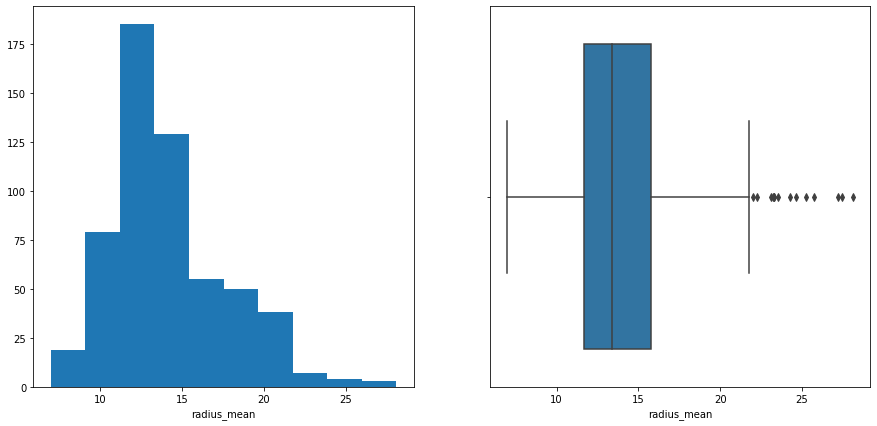

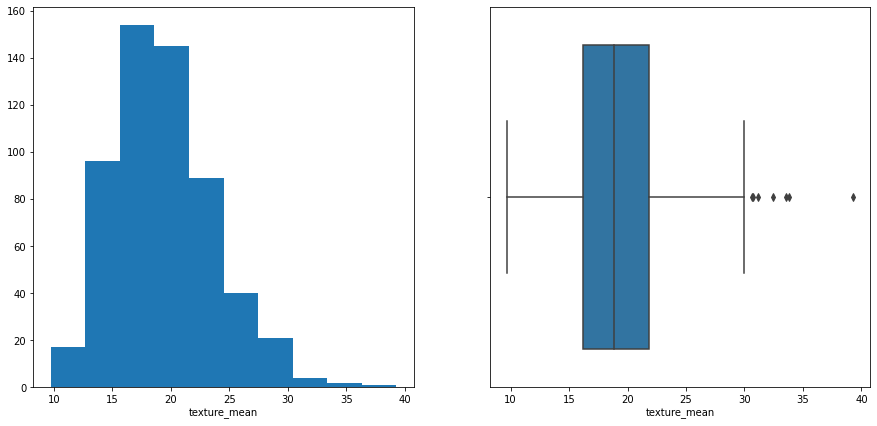

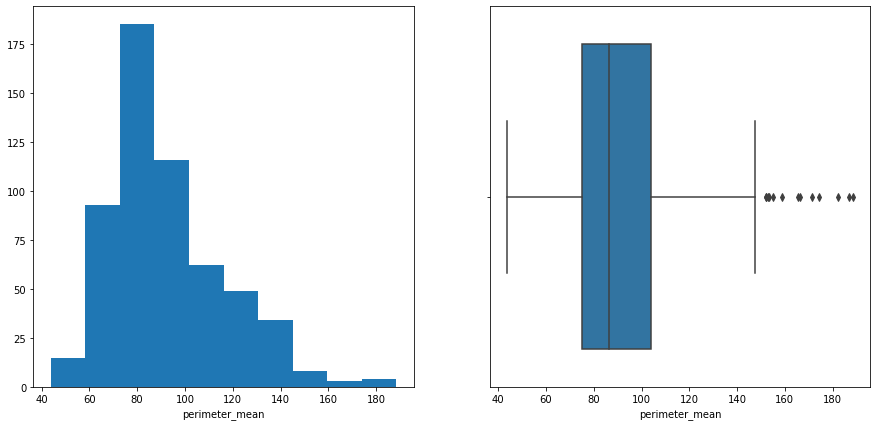

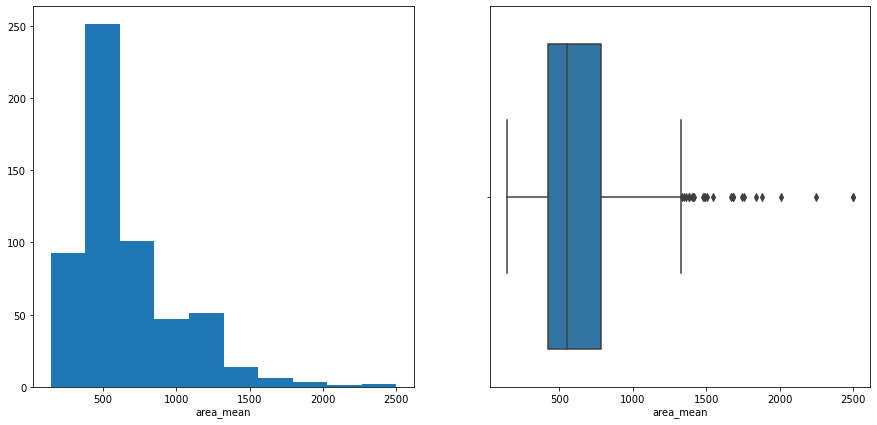

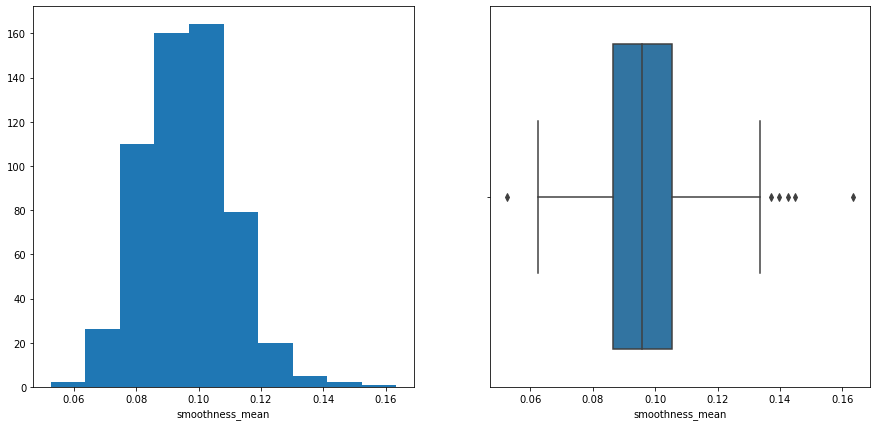

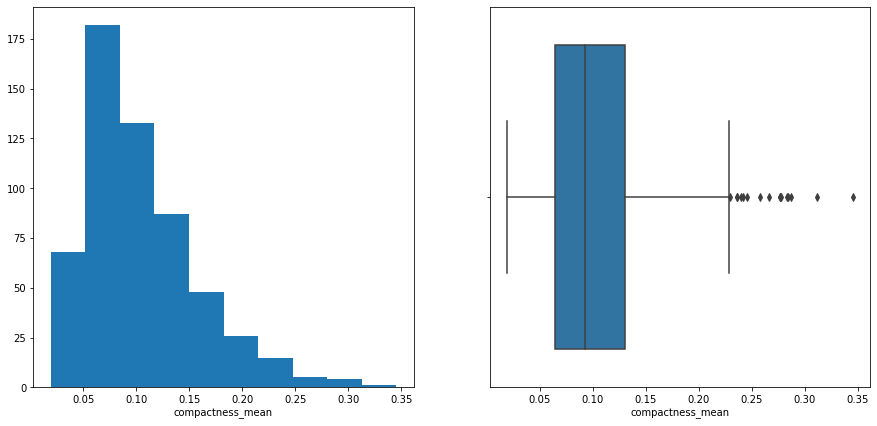

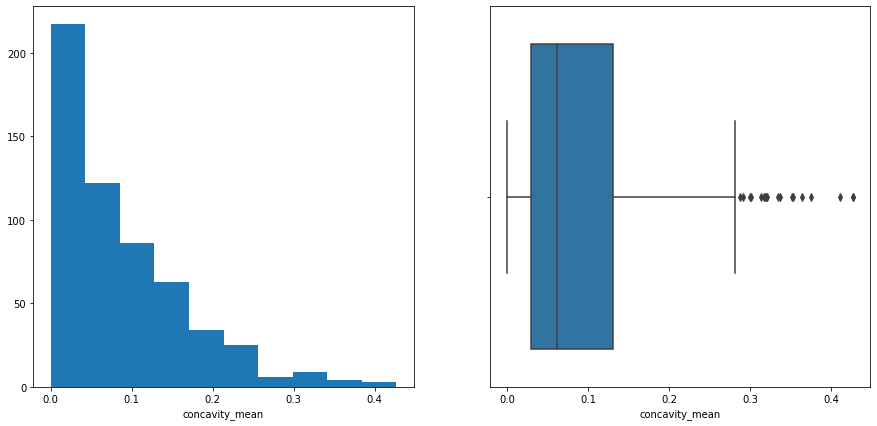

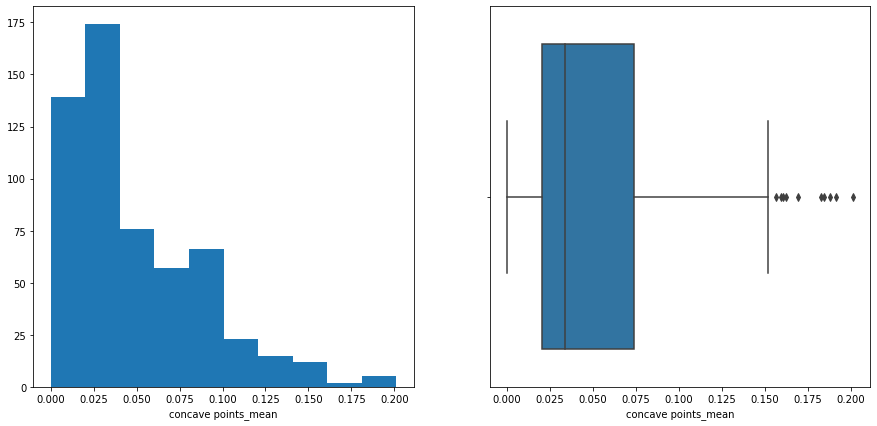

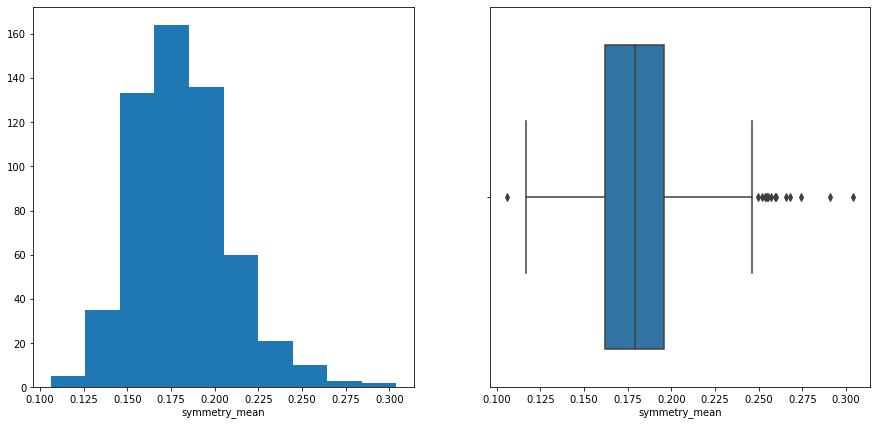

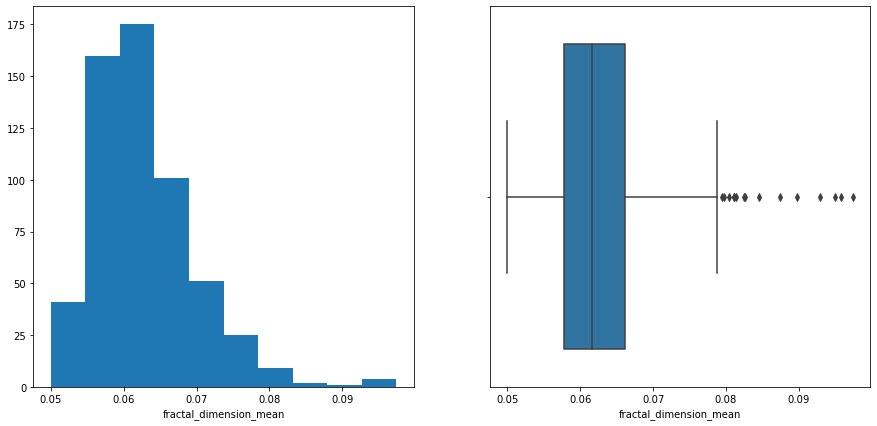

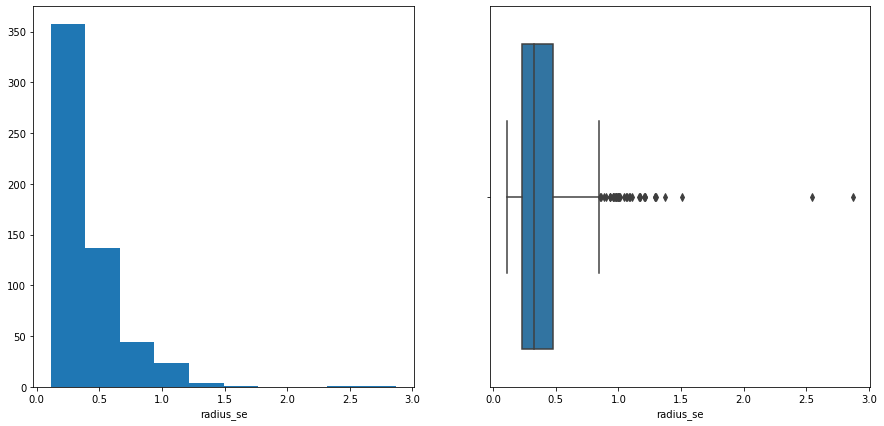

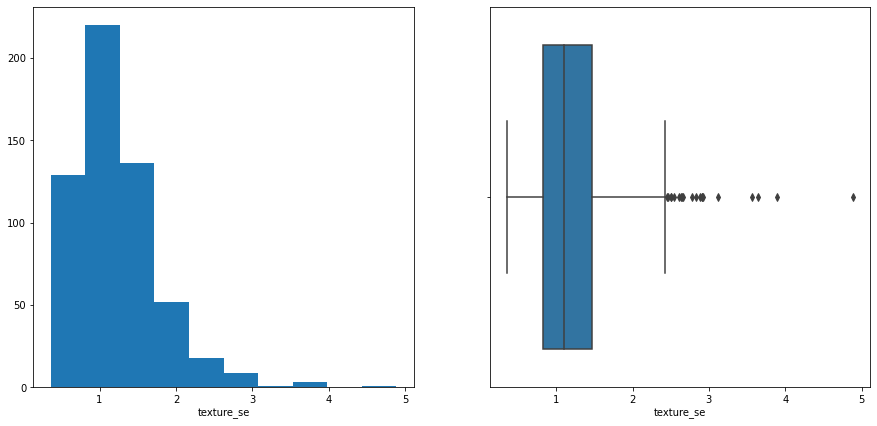

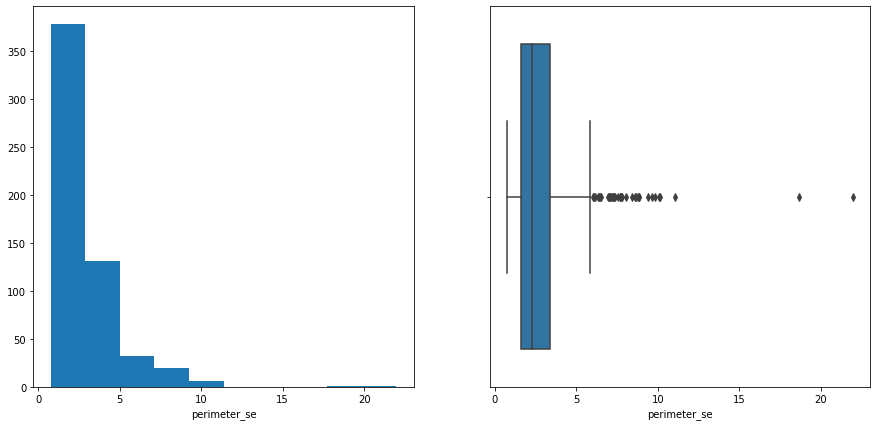

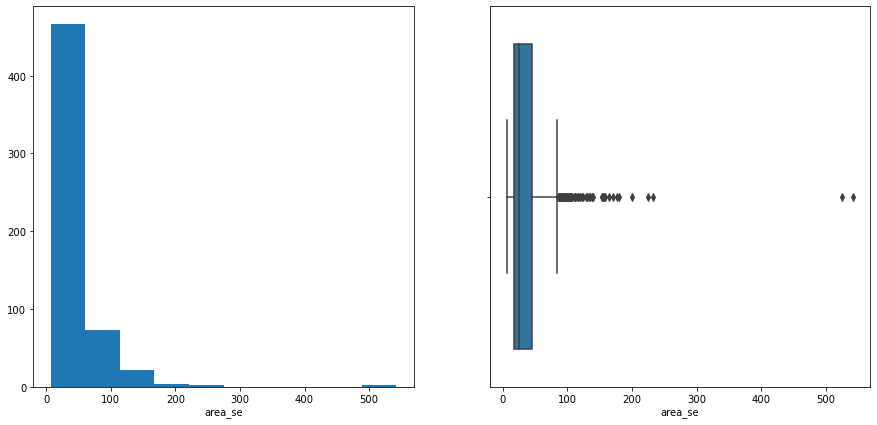

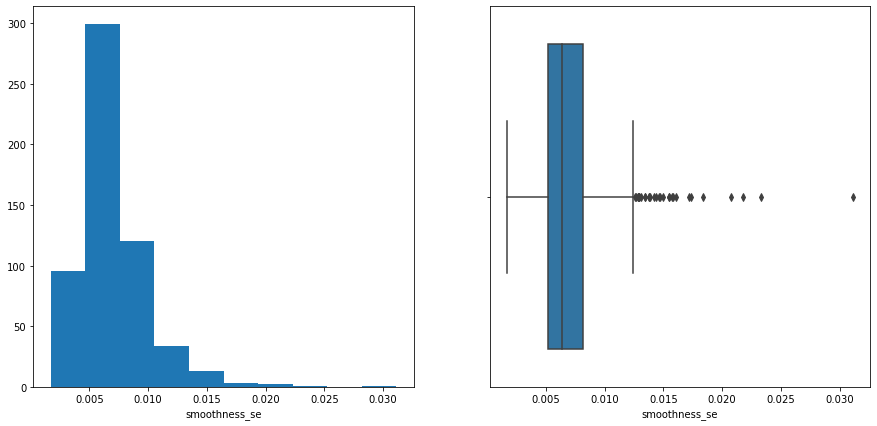

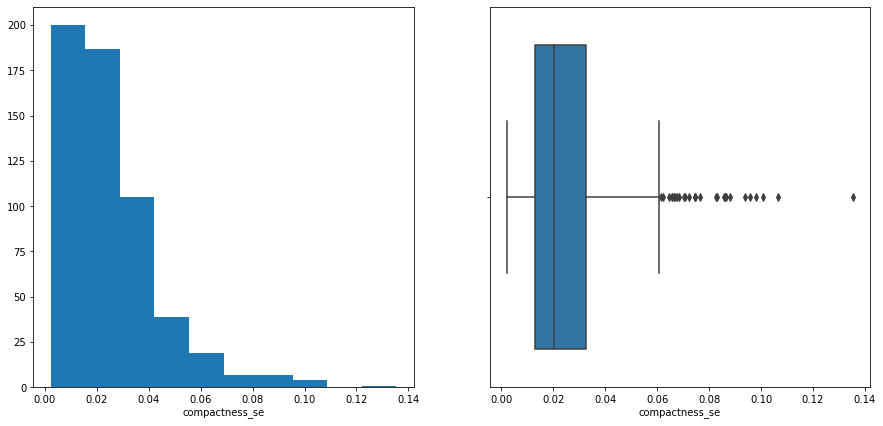

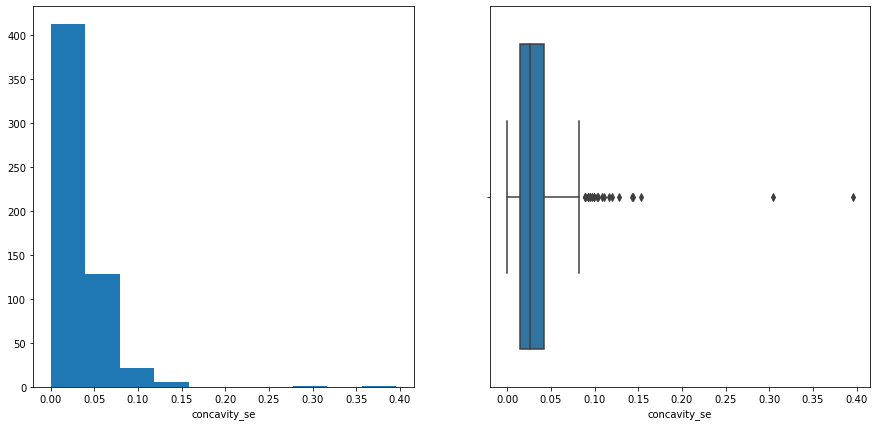

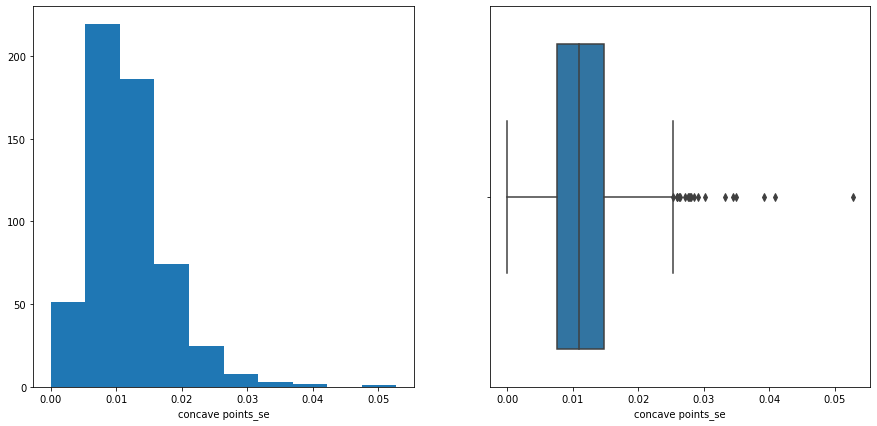

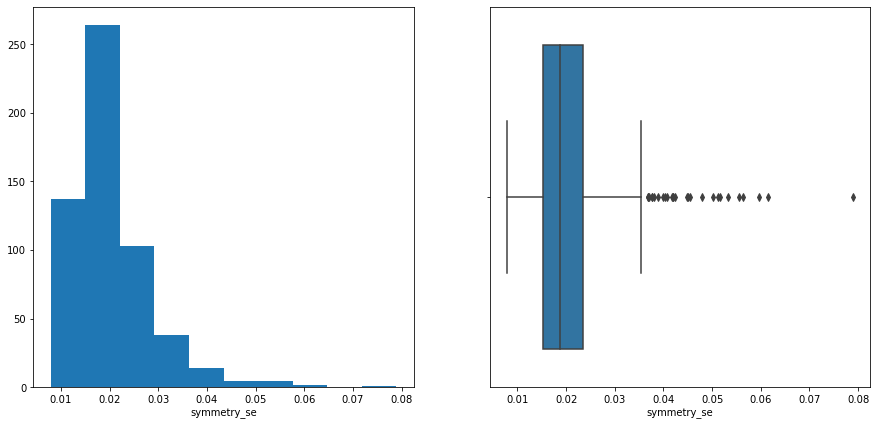

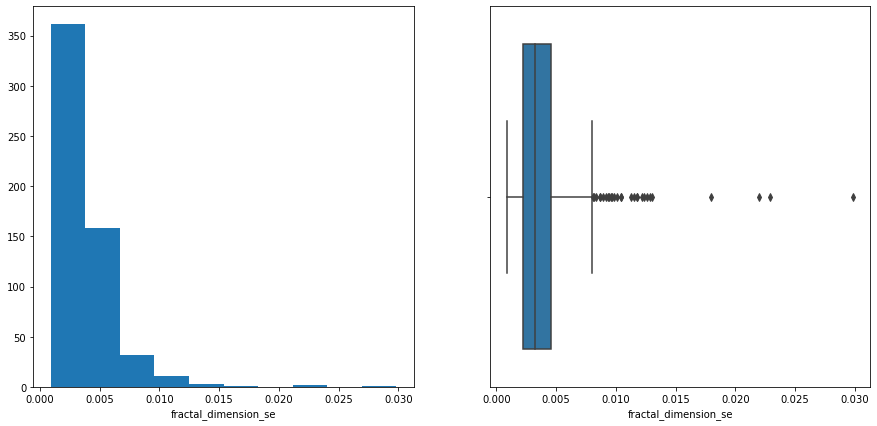

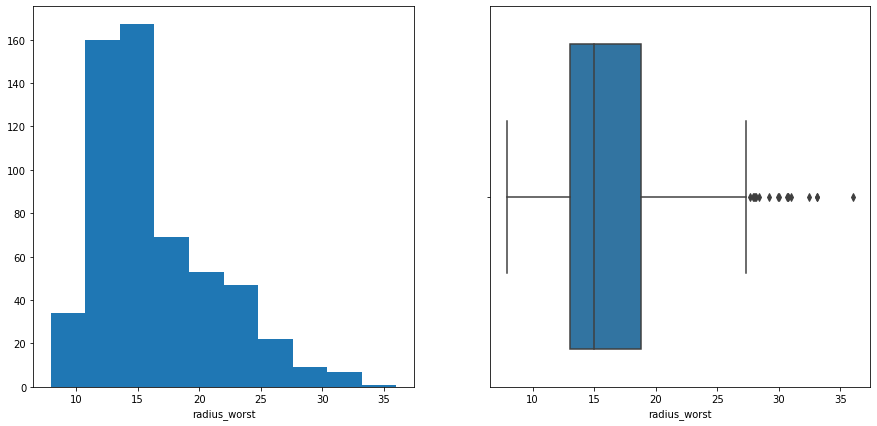

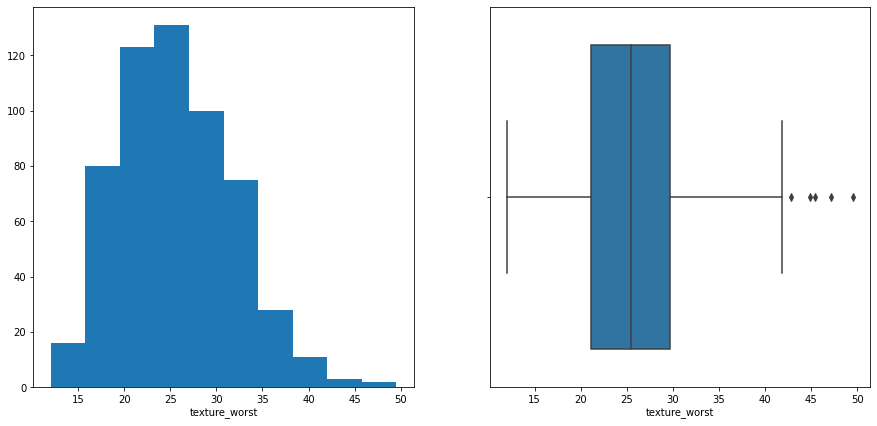

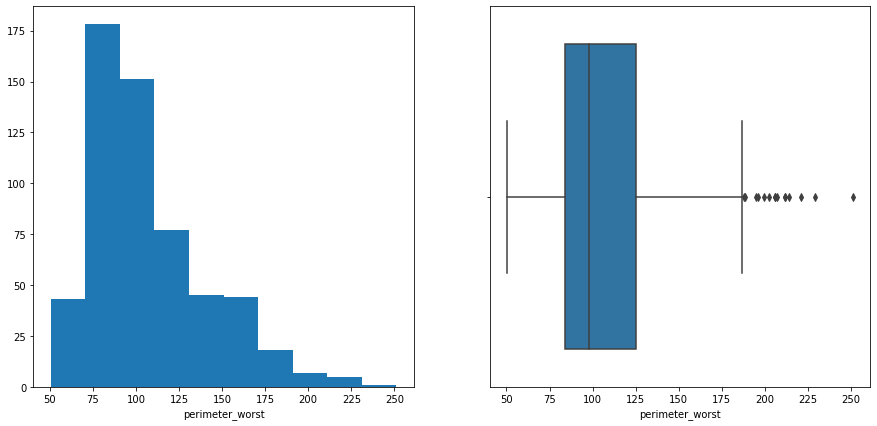

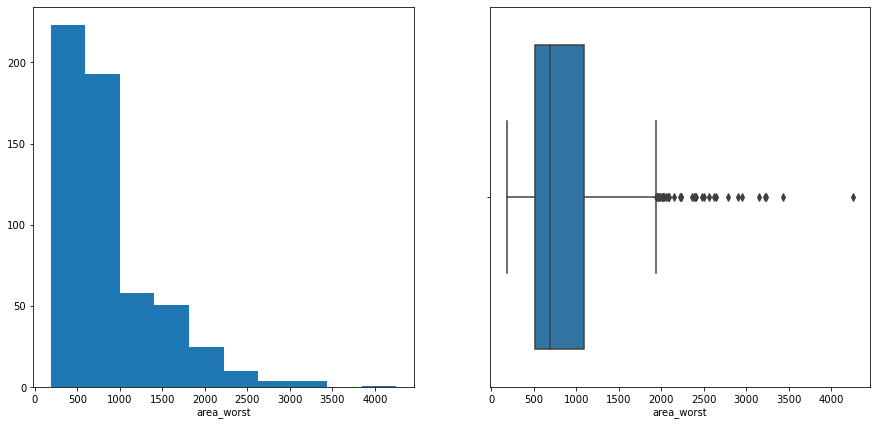

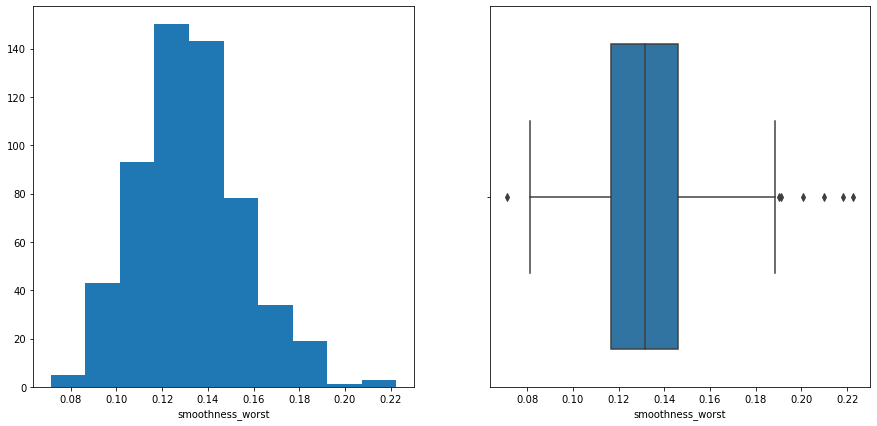

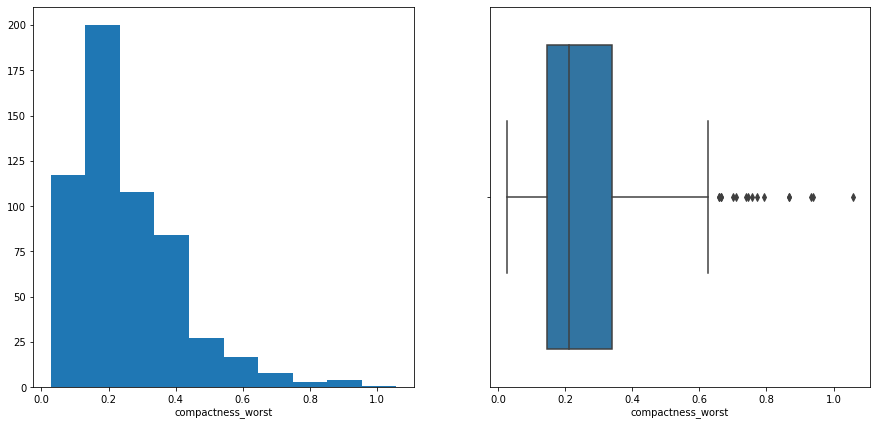

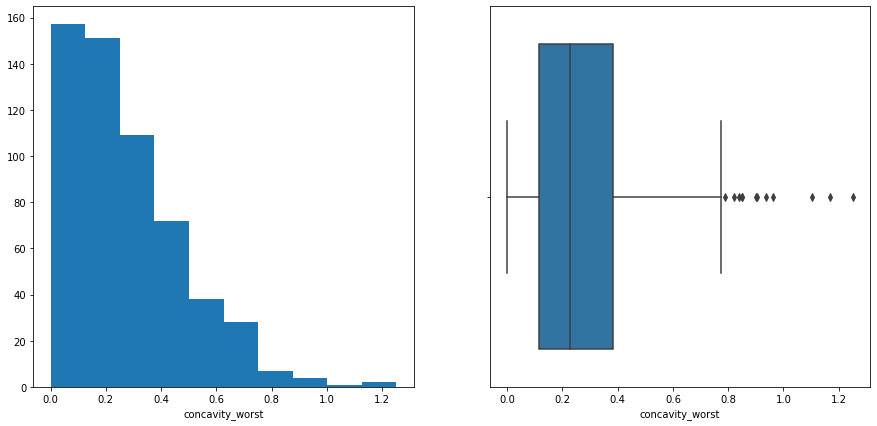

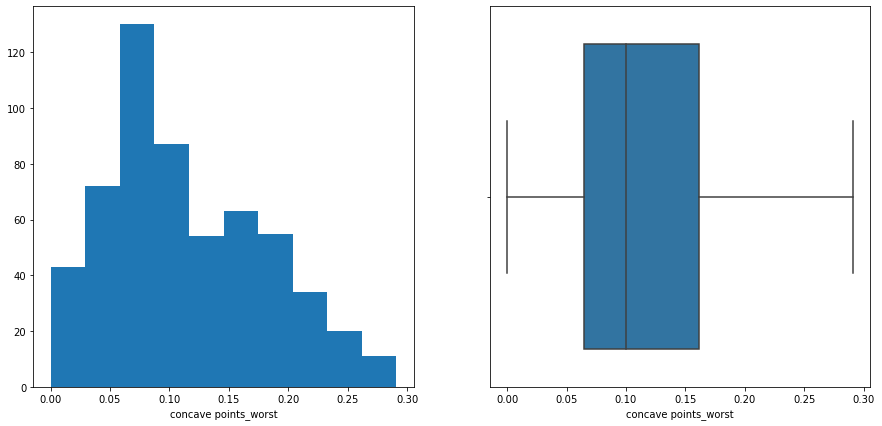

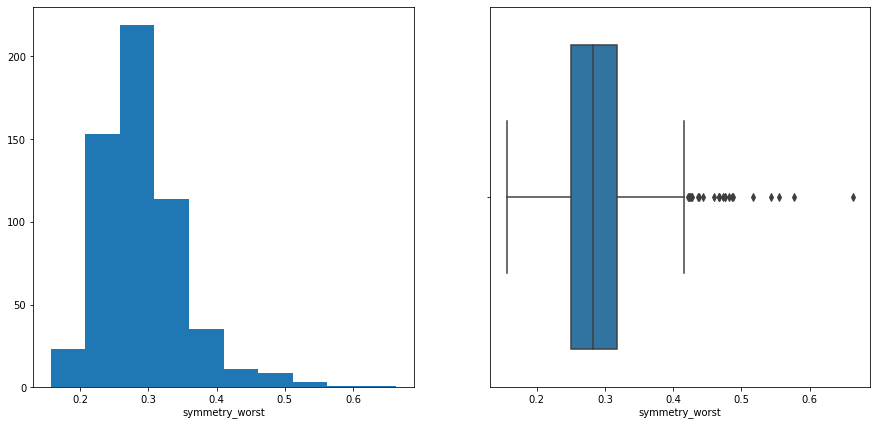

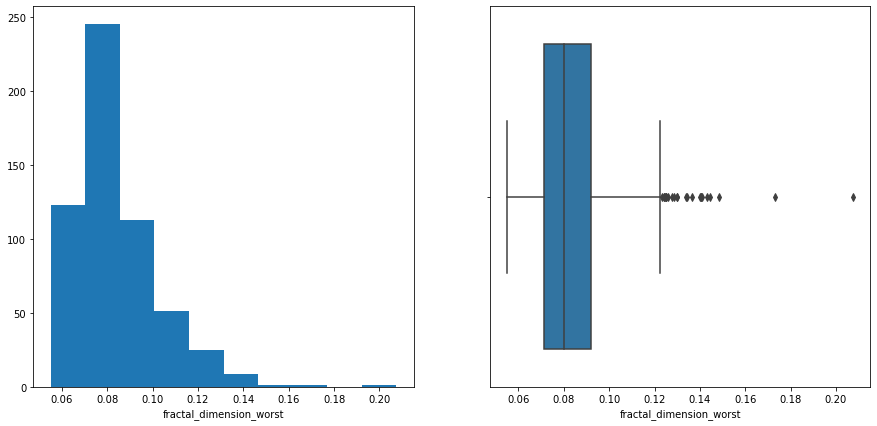

In [5]:
f.univariate_numerical_analysis(df, numerical_columns)

right-skewed distributions: radius_mean, texture_mean, perimeter_mean, area_mean, compactness_mean, concavity_mean, concave_points_mean, fractal_dimension_mean, radius_se, texture_se, perimeter_se, area_se, smoothness_se, compactness_se, concavity_se, concave_points_se, symmetry_se, fractal_dimension_se, radius_worst, perimeter_worst, area_worst, compactness_worst, concavity_worst, concave_points_worst, symmetry_worst, fractal_dimension_worst
centered distributions: smoothness_mean, symmetry_mean, texture_worst, smoothness_worst, 

## Bivariate Analysis

The plots below show the distributions of each feature across benign and malignant tumors. The aim is to identify features where these distributions are significantly different. For similar distributions, it is likely that such feature might not help the classifier distinguish between these types of tumors.

A visual analysis suggest these features might be candidates for exclusion since their distributions are not easily distinguishable: smoothness_mean, symmetry_mean, fractal_dimension_mean, radius_se, texture_se, perimeter_se, area_se, smoothness_se, compactness_se, concavity_se, symmetry_se, fractal_dimension_se, symmetry_worst, fractal_dimension_worst, 

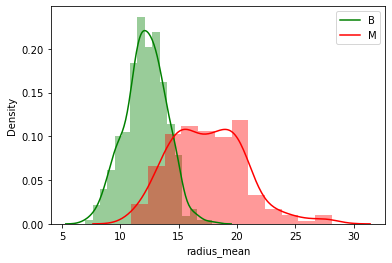

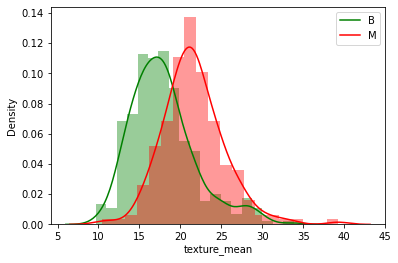

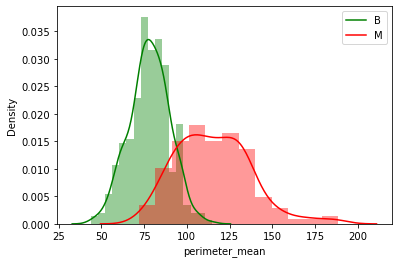

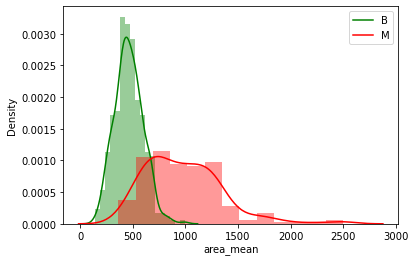

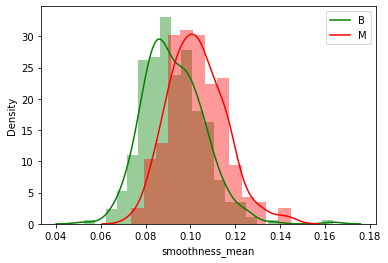

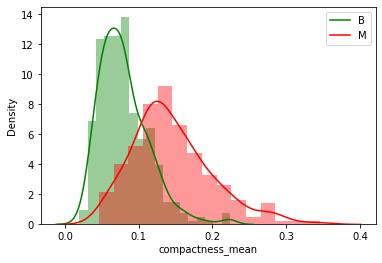

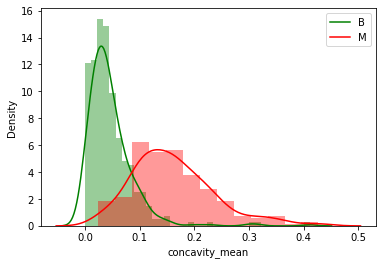

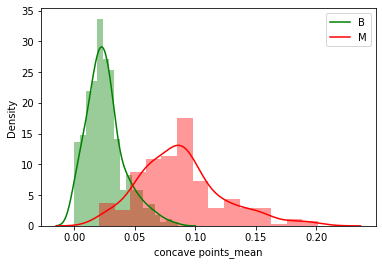

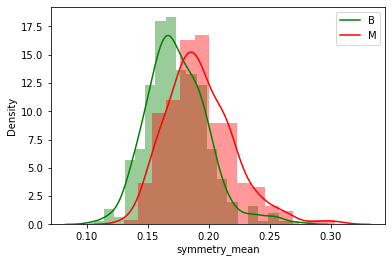

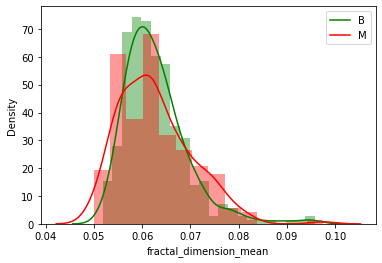

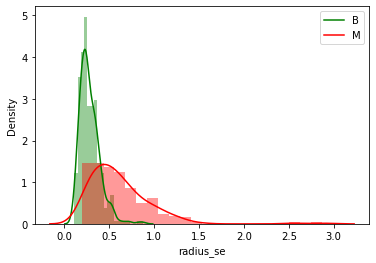

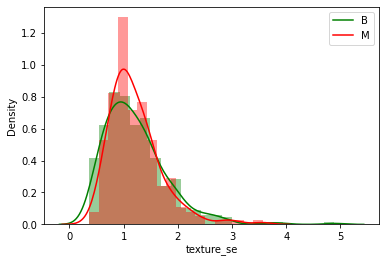

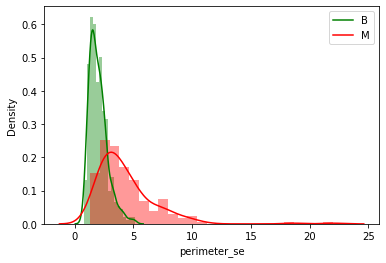

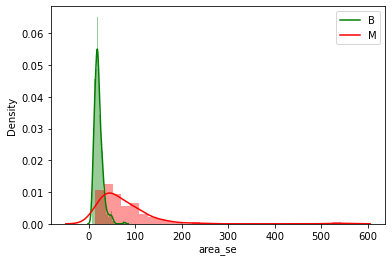

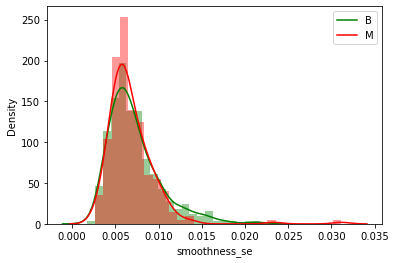

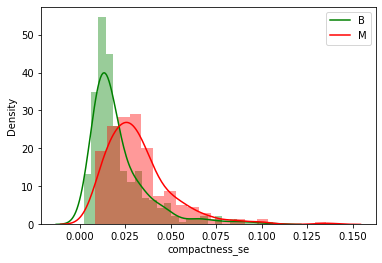

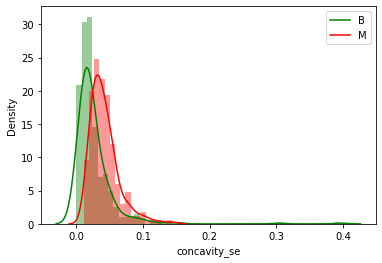

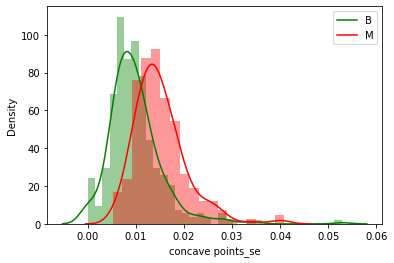

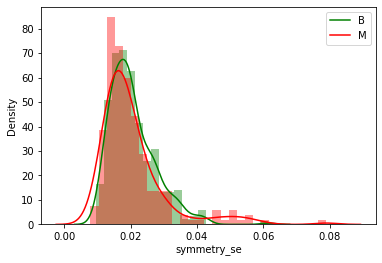

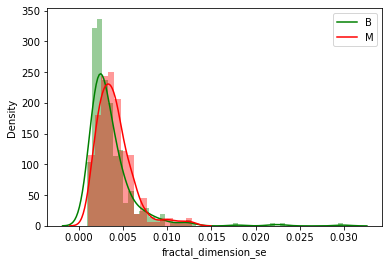

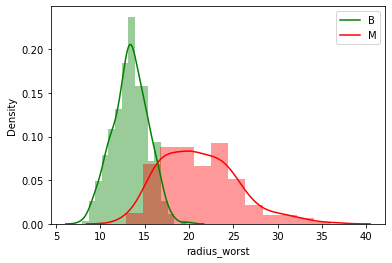

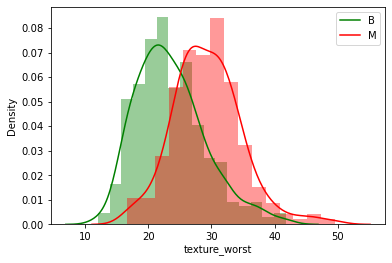

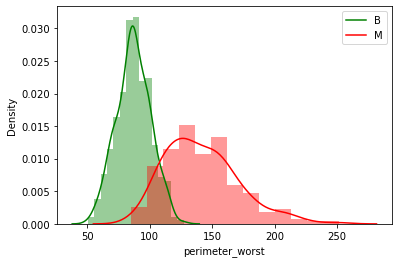

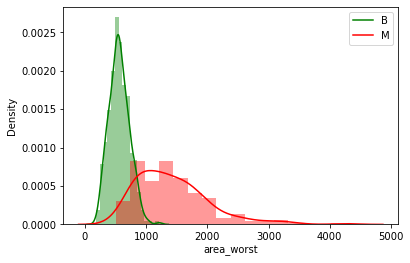

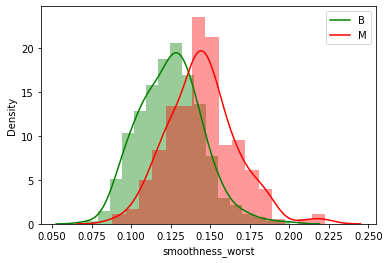

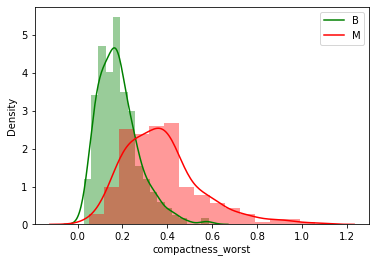

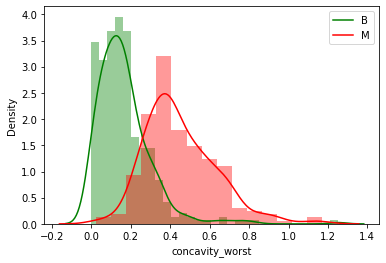

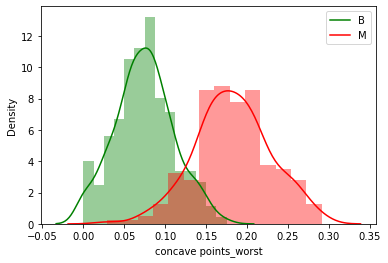

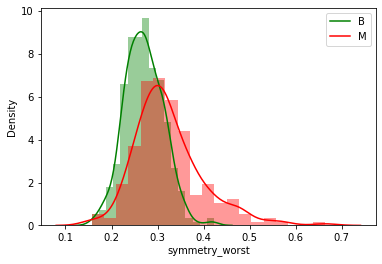

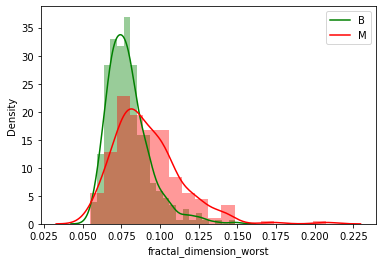

In [6]:
f.bivariate_analysis_numerical(df, numerical_columns, 'diagnosis', 'B', 'M')

We conduct a mannwhitneyu test on all the distributions.

H0 (null hypothesis): The means of the distributions for benign and malignant tumors are the same.

Ha (alternate hypothesis): The means of the distributions for benign and malignant tumors are different.

We want to exclude features which fail to reject the null hypothesis.

##### Statistical Testing

Note: We would generally run t-tests on the numerical variables, however, the issue is that not all the of variables follow a normal distribution, and since we do not want turn to such strong assumptions, we run the mannwhitneyu test. Theortically, we should be running the wilcoxon test; however, the problem with the wilcoxon test is that it only works if the number of samples in each of the distributions is the same. This is not the case for us hence we opt for the mannwhitheyu test.

In [7]:
print("Numerical Variables")
for column in numerical_columns:
    f.mannwhitneyu(column, df, output = 'diagnosis', output_1 = 'B',output_2= 'M')

Numerical Variables
fractal_dimension_mean :similar means between the two groups (fail to reject H0) 0.26859280106781197
texture_se :similar means between the two groups (fail to reject H0) 0.32184635051298305
smoothness_se :similar means between the two groups (fail to reject H0) 0.10681581660023132


In [8]:
df_stats = df.copy()
df_stats = df_stats.drop(['fractal_dimension_mean', 'texture_se', 'smoothness_se'], axis =1)

In [9]:
df_stats_column = numerical_columns[ ~numerical_columns.isin(['fractal_dimension_mean', 'texture_se', 'smoothness_se'])]

In [10]:
df = f.standard_scaler(df, numerical_columns)
df_stats = f.power_transform(df_stats, df_stats_column)

## Classification

Wee explore 32 different classifiers and compare their accuracies for the reduced feature set and the complete feature set. We then take the mean score for the reduced and complete set and test whether the difference between them is statistically significant, to determine advantage of taking the statistical approach to feature selection.

We also exclude all features that have a low variance using Sklearn's inbuilt functionality.

It is important to note we take the classifiers as they are, with no fitting or fine tuning, and evaluate their accuracy which allows us to compare baseline models. The goal of this feature selection is to increase the baseline accuracy, not to increase the final fine-tuned accuracy, hence this approach is taken.

In [11]:
# sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
# X_df_stats = sel.fit_transform(df_stats.drop('diagnosis', axis =1))
# y_df_stats = df_stats['diagnosis']
X_df_stats = df_stats.drop('diagnosis', axis =1)
y_df_stats = df_stats['diagnosis']

In [12]:
(X_train, X_test, y_train, y_test) = f.train_test_split(df.drop('diagnosis', axis =1), df['diagnosis'])
(X_train_df, X_test_df, y_train_df, y_test_df) = f.train_test_split(X_df_stats, y_df_stats)

0.9541910331384015 0.9446393762183234


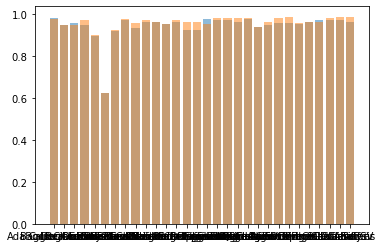

In [13]:
classifier_names_df = []
classifier_names_df_stats = []

classifier_scores_df = []
classifier_scores_df_stats = []

estimators = all_estimators(type_filter='classifier')

for name, ClassifierClass in estimators:
    try:
        classifier_names_df, classifier_scores_df = f.score(name, ClassifierClass, X_train, X_test, y_train, y_test, classifier_names_df, classifier_scores_df)
        classifier_names_df_stats, classifier_scores_df_stats = f.score(name, ClassifierClass, X_train_df, X_test_df, y_train_df, y_test_df, classifier_names_df_stats, classifier_scores_df_stats)
    except Exception as e:
        1+1
print(np.mean(classifier_scores_df_stats), np.mean(classifier_scores_df))
plt.bar(classifier_names_df,classifier_scores_df, alpha = 0.5)
plt.bar(classifier_names_df_stats,classifier_scores_df_stats, alpha = 0.5)
plt.show()

H0: The means of the accuracy on the reduced feature set and complete feature set are the same.

Ha: The means of the accuracy on the reduced feature set and complete feature set are the same.

We set the alpha in the final test to 0.1. The reason for doing this is because, the number of samples that we are dealing with quite low, so we need to account for that room for error (which can be reflected in the alpha), 

We can run the wilcoxon test on the following hypothesis test, because the number of samples is the same (this was unlike when we were removing the features which which were not statistically signficant). 

In [14]:
value = scipy.stats.wilcoxon(classifier_scores_df,classifier_scores_df_stats)
p_value = value[1]

print(p_value)
if abs(p_value) <= 0.1:
    print(column, ':different means between the two groups (reject H0)')
else:
    print(column, ':similar means between the two groups (fail to reject H0)')

0.0014932325730101198
fractal_dimension_worst :different means between the two groups (reject H0)


## Conclusion

#### There is a statistical difference between the two algorithms

We conclude that the accuracy increases across the tested classifiers with statistical significance when passing a reduced feature seet from which all the statistically insignificant features were excluded.